<a href="https://colab.research.google.com/github/aryantandon01/Stock-Prediction/blob/main/Stock%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.737653
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.879066
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013701
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.993060
...,...,...,...,...,...,...
2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,67.112915
2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,67.283928
2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,68.198540


In [ ]:
# Rows and columns
df.shape

(2003, 6)

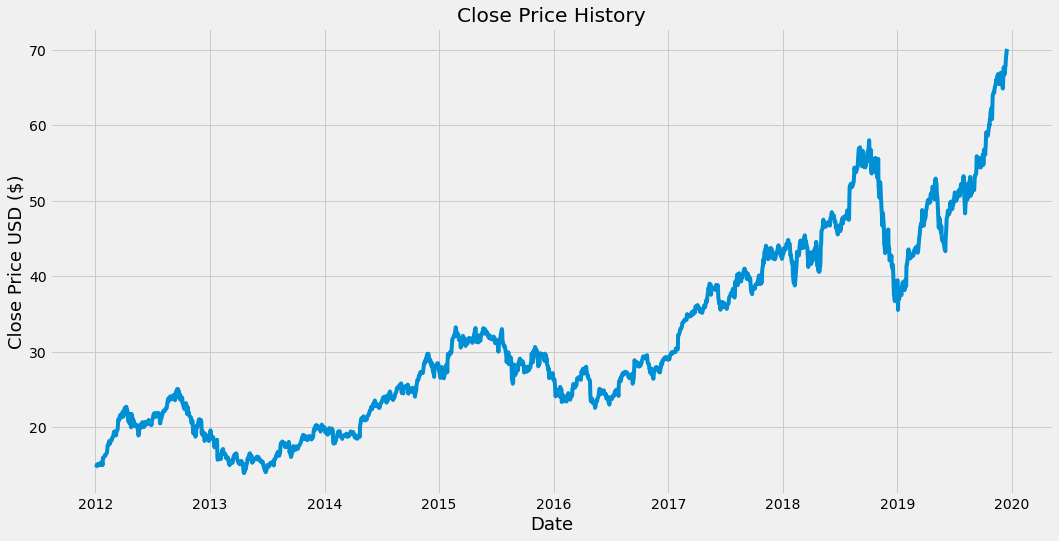

In [ ]:
#Visualisation of Closing Prices
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [ ]:
#Scale all of the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#x_train.shape[0] is 1543 and x_train.shape[1] is 60, so we can also replace those two indices with these numbers.

In [ ]:
#Build the LSTM model
model = Sequential()
#1st LSTM layer
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
#50 indicates there are 50 neurons
#2nd LSTM layer
model.add(LSTM(units=50, return_sequences=False))
#It's false because we're not going to use anymore LSTM layers for our model's architecture
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Optimizer is used to improve upon the loss function
#Loss function tells how the model did on training

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)
#Fit is another name for train
#Batch size is the total number of training examples present in a single batch
#epochs = Number of iterations when the entire dataset has passed forward and backwar through a neural network

1543/1543 [==============================] - 39s 23ms/step - loss: 0.0018


In [ ]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , : ]
#The ':' after the comma means we want back all of the columns

#Create the datat sets x_test and y_test
x_test = []
y_test =  dataset[training_data_len : , : ] 
#Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
#Reshape the model cos the LSTM model is expecting a 3-D Data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#1 is the closed price

In [ ]:
#Get the model's predicted price value 
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
#Undo Scaling
#We want the predictions dataset to contain the same values as y_test dataset

In [ ]:
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.5836753927838316

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


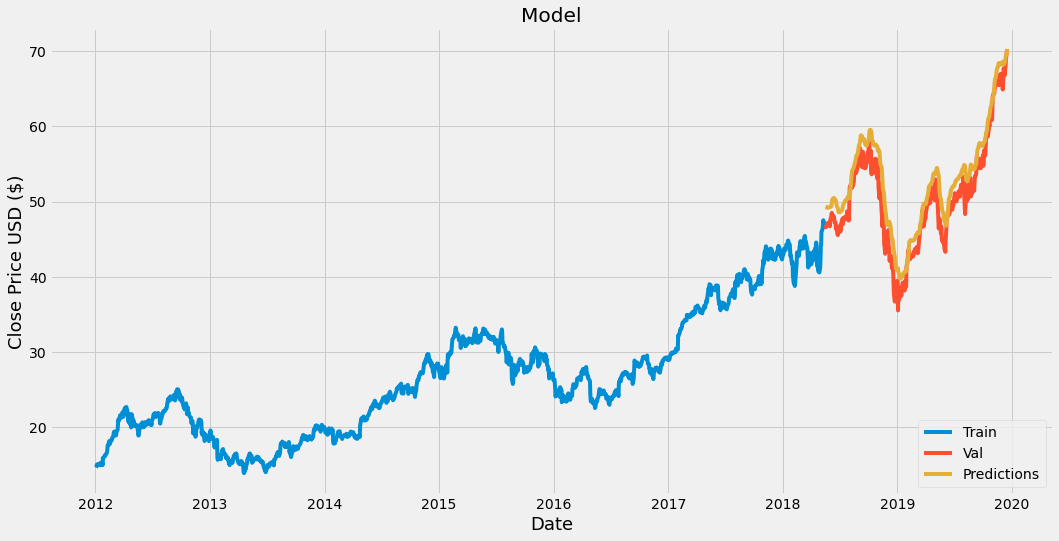

In [ ]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,49.313587
2018-05-18,46.577499,49.299488
2018-05-21,46.907501,49.225281
2018-05-22,46.790001,49.182030
2018-05-23,47.090000,49.141914
...,...,...
2019-12-11,67.692497,68.822250
2019-12-12,67.864998,69.083717
2019-12-13,68.787498,69.353027


In [ ]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days into X_test list
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scale price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[70.78463]]


In [ ]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    69.934998
Name: Close, dtype: float64
